# Description

This notebook contains the interpretation of a cluster (which features/latent variables in the original data are useful to distinguish traits in the cluster).

See section [LV analysis](#lv_analysis) below

# Modules loading

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import re
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# from IPython.display import HTML
from tqdm import tqdm

from clustering.methods import ClusterInterpreter
from data.recount2 import LVAnalysis
from data.cache import read_data
import conf

# Settings

In [3]:
# PARTITION_K = 26
# PARTITION_CLUSTER_ID = 18

In [4]:
OUTPUT_DIR = conf.RESULTS["DRUG_DISEASE_ANALYSES"] / "lincs" / "analyses"
display(OUTPUT_DIR)
OUTPUT_DIR.mkdir(exist_ok=True, parents=True)

PosixPath('/media/miltondp/Elements1/projects/phenoplier/results/drug_disease_analyses/lincs/analyses')

In [5]:
OUTPUT_FIGURES_DIR = Path(
    conf.MANUSCRIPT["FIGURES_DIR"], "drug_disease_prediction"
).resolve()
display(OUTPUT_FIGURES_DIR)
OUTPUT_FIGURES_DIR.mkdir(parents=True, exist_ok=True)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier_manuscript/content/images/drug_disease_prediction')

# Load MultiPLIER summary

In [6]:
multiplier_model_summary = read_data(conf.MULTIPLIER["MODEL_SUMMARY_FILE"])

In [7]:
multiplier_model_summary.shape

(2157, 5)

In [8]:
multiplier_model_summary.head()

,pathway,LV index,AUC,p-value,FDR
1,KEGG_LYSINE_DEGRADATION,1,0.388059,0.866078,0.956005
2,REACTOME_MRNA_SPLICING,1,0.733057,0.000048,0.000582
3,MIPS_NOP56P_ASSOCIATED_PRE_RRNA_COMPLEX,1,0.680555,0.001628,0.011366
4,KEGG_DNA_REPLICATION,1,0.549473,0.312155,0.539951
5,PID_MYC_ACTIVPATHWAY,1,0.639303,0.021702,0.083739


# Load data

## Original data

In [9]:
INPUT_SUBSET = "z_score_std"

In [10]:
INPUT_STEM = "projection-smultixcan-efo_partial-mashr-zscores"

In [11]:
input_filepath = Path(
    conf.RESULTS["DATA_TRANSFORMATIONS_DIR"],
    INPUT_SUBSET,
    f"{INPUT_SUBSET}-{INPUT_STEM}.pkl",
).resolve()
display(input_filepath)

assert input_filepath.exists(), "Input file does not exist"

input_filepath_stem = input_filepath.stem
display(input_filepath_stem)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier/bases_data/base_orig/results/data_transformations/z_score_std/z_score_std-projection-smultixcan-efo_partial-mashr-zscores.pkl')

'z_score_std-projection-smultixcan-efo_partial-mashr-zscores'

In [12]:
data = pd.read_pickle(input_filepath)

In [13]:
data.shape

(3752, 987)

In [14]:
data.head()

,LV1,LV2,LV3,LV4,LV5,LV6,LV7,LV8,LV9,LV10,...,LV978,LV979,LV980,LV981,LV982,LV983,LV984,LV985,LV986,LV987
100001_raw-Food_weight,-0.695006,1.962565,0.057683,0.878731,-0.539977,1.481272,-0.396422,1.090180,0.759223,0.931395,...,1.129784,1.752343,-1.411403,2.823863,0.931116,-1.054519,0.432982,-0.633597,0.554279,-0.642479
100002_raw-Energy,-1.528127,-0.345309,-0.148953,-0.242060,0.373427,0.791092,0.263477,0.987702,0.354391,1.416059,...,0.224604,0.769882,-0.509482,0.091153,2.286789,-1.008256,-0.029764,1.737229,-0.272107,-0.526125
100003_raw-Protein,-0.704572,-1.011299,0.671420,0.143991,0.615212,0.874212,-0.040998,0.915170,0.254369,-0.084237,...,1.003019,1.044314,-2.376108,0.004778,0.053714,-0.892447,-0.183800,1.377991,-0.278794,-0.419733
100004_raw-Fat,-0.989832,-1.875490,0.261555,-1.420719,0.366238,1.167049,0.257387,0.717674,-0.997664,0.969825,...,0.585913,0.638314,0.119139,-0.140204,1.394326,-1.173402,0.555058,1.013982,-0.544506,-0.064061
100005_raw-Carbohydrate,-0.580143,0.243335,0.158966,-0.036558,0.068176,-0.202639,1.101281,0.675227,1.463432,1.010078,...,-0.249108,-0.026814,0.232713,0.323682,1.168642,-0.282935,0.653105,1.909526,0.199997,-1.656894


## Clustering partitions

In [15]:
# CONSENSUS_CLUSTERING_DIR = Path(
#     conf.RESULTS["CLUSTERING_DIR"], "consensus_clustering"
# ).resolve()

# display(CONSENSUS_CLUSTERING_DIR)

In [16]:
# input_file = Path(CONSENSUS_CLUSTERING_DIR, "best_partitions_by_k.pkl").resolve()
# display(input_file)

In [17]:
# best_partitions = pd.read_pickle(input_file)

In [18]:
# best_partitions.shape

In [19]:
# best_partitions.head()

# Functions

In [20]:
# def show_cluster_stats(data, partition, cluster):
#     cluster_traits = data[partition == cluster].index
#     display(f"Cluster '{cluster}' has {len(cluster_traits)} traits")
#     display(cluster_traits)

# LV analysis
<a id="lv_analysis"></a>

## Associated traits

In [21]:
# display(best_partitions.loc[PARTITION_K])
# part = best_partitions.loc[PARTITION_K, "partition"]

In [22]:
# show_cluster_stats(data, part, PARTITION_CLUSTER_ID)

## Associated latent variables

In [23]:
# ci = ClusterInterpreter(
#     threshold=1.0,
#     max_features=20,
#     max_features_to_explore=100,
# )

In [24]:
# ci.fit(data, part, PARTITION_CLUSTER_ID)

In [25]:
# ci.features_

In [26]:
# # save interpreter instance
# output_dir = Path(
#     conf.RESULTS["CLUSTERING_INTERPRETATION"]["BASE_DIR"],
#     "cluster_lvs",
#     f"part{PARTITION_K}",
# )
# output_dir.mkdir(exist_ok=True, parents=True)

In [27]:
# output_file = Path(
#     output_dir, f"cluster_interpreter-part{PARTITION_K}_k{PARTITION_CLUSTER_ID}.pkl"
# )
# display(output_file)

In [28]:
# ci.features_.to_pickle(output_file)

## Top attributes

In [29]:
output_file = OUTPUT_DIR / "cardiovascular-niacin.h5"
display(output_file)

PosixPath('/media/miltondp/Elements1/projects/phenoplier/results/drug_disease_analyses/lincs/analyses/cardiovascular-niacin.h5')

In [30]:
with pd.HDFStore(output_file, mode="r") as store:
    traits_module_tissue_data = store["traits_module_tissue_data"]
    drug_data = store["drug_data"]
    drug_trait_predictions = store["drug_trait_predictions"]

In [31]:
top_lvs = drug_trait_predictions["CARDIoGRAM_C4D_CAD_ADDITIVE"].sort_values(
    ascending=True
)
top_lvs = top_lvs[top_lvs < 0.0]

In [32]:
top_lvs.shape

(497,)

In [33]:
top_lvs

LV38    -6.532010e-03
LV881   -4.782590e-03
LV116   -4.640577e-03
LV163   -2.453669e-03
LV74    -2.268123e-03
             ...     
LV501   -1.095653e-06
LV809   -3.631848e-07
LV86    -2.728704e-07
LV404   -1.182699e-08
LV916   -7.352906e-09
Name: CARDIoGRAM_C4D_CAD_ADDITIVE, Length: 497, dtype: float64

In [34]:
lvs_list = top_lvs.index.tolist()

In [35]:
len(lvs_list)

497

In [36]:
lvs_list[:10]

['LV38',
 'LV881',
 'LV116',
 'LV163',
 'LV74',
 'LV1',
 'LV509',
 'LV824',
 'LV840',
 'LV189']

In [37]:
def _my_func(x):
    _cols = [c for c in x.index if not c.startswith("LV")]
    _tmp = x[_cols].dropna()
    if _tmp.shape[0] > 0:
        return _tmp.iloc[0]

    return None

In [38]:
cell_type_dfs = []
tissue_dfs = []

pbar = tqdm(lvs_list[:50])
for lv_name in pbar:
    pbar.set_description(lv_name)

    #     lv_name = lv_info["name"]
    lv_obj = LVAnalysis(lv_name, data)

    #     # show lv prior knowledge match (pathways)
    #     lv_pathways = multiplier_model_summary[
    #         multiplier_model_summary["LV index"].isin((lv_name[2:],))
    #         & (
    #             (multiplier_model_summary["FDR"] < 0.05)
    #             | (multiplier_model_summary["AUC"] >= 0.75)
    #         )
    #     ]
    #     display(lv_pathways)

    lv_data = lv_obj.get_experiments_data()

    #     display("")
    #     display(lv_obj.lv_traits.head(20))
    #     display("")
    #     display(lv_obj.lv_genes.head(10))

    # get cell type attributes
    #     lv_attrs = lv_obj.get_attributes_variation_score()
    lv_attrs = pd.Series(lv_data.columns.tolist())
    lv_attrs = lv_attrs[
        lv_attrs.str.match(
            "(?:cell[^\w]*type$)",
            case=False,
            flags=re.IGNORECASE,
        ).values
    ].sort_values(ascending=False)
    display(lv_attrs)

    lv_attrs_data = lv_data[lv_attrs.tolist() + [lv_name]]
    lv_attrs_data = lv_attrs_data.assign(attr=lv_attrs_data.apply(_my_func, axis=1))
    lv_attrs_data = lv_attrs_data.drop(columns=lv_attrs.tolist())
    lv_attrs_data = lv_attrs_data.dropna().sort_values(lv_name, ascending=False)
    lv_attrs_data = lv_attrs_data.rename(columns={lv_name: "lv"})
    lv_attrs_data = lv_attrs_data.assign(lv_name=lv_name)
    cell_type_dfs.append(lv_attrs_data)

    # get tissue attributes
    lv_attrs = pd.Series(lv_data.columns.tolist())
    lv_attrs = lv_attrs[
        lv_attrs.str.match(
            "(?:tissue$)|(?:tissue[^\w]*type$)",
            case=False,
            flags=re.IGNORECASE,
        ).values
    ].sort_values(ascending=False)
    display(lv_attrs)

    lv_attrs_data = lv_data[lv_attrs.tolist() + [lv_name]]
    lv_attrs_data = lv_attrs_data.assign(attr=lv_attrs_data.apply(_my_func, axis=1))
    lv_attrs_data = lv_attrs_data.drop(columns=lv_attrs.tolist())
    lv_attrs_data = lv_attrs_data.dropna().sort_values(lv_name, ascending=False)
    lv_attrs_data = lv_attrs_data.rename(columns={lv_name: "lv"})
    lv_attrs_data = lv_attrs_data.assign(lv_name=lv_name)
    tissue_dfs.append(lv_attrs_data)

LV38:   0%|          | 0/50 [00:00<?, ?it/s]

SRP066834, SRP050499, SRP042161, SRP057196, SRP033135, SRP028301, SRP055153, SRP059775, SRP059035, SRP030617, SRP058773, SRP055569, SRP052294, SRP060598, SRP055810, SRP028570, SRP055101, SRP011546, SRP050992, SRP062177, SRP015138, SRP014428, 

5    cell type
dtype: object

1    tissue
dtype: object

LV881:   2%|▏         | 1/50 [00:12<09:51, 12.07s/it]

SRP042161, SRP050499, SRP066834, SRP060416, SRP057196, SRP055569, SRP018525, SRP059035, SRP028301, SRP062773, SRP033135, SRP050440, SRP059379, SRP048603, SRP044917, SRP041102, SRP059775, SRP048604, SRP034711, SRP035312, SRP055101, SRP055153, SRP014428, SRP041255, SRP042286, SRP021509, SRP045570, SRP018838, SRP060370, SRP030617, SRP064457, SRP015138, SRP007461, SRP053186, SRP064259, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (34 != 35)
  warnings.warn(


1    cell type
dtype: object

7    tissue
dtype: object

LV116:   4%|▍         | 2/50 [00:25<09:59, 12.48s/it]

SRP059039, SRP045500, SRP063059, SRP045569, SRP015670, SRP059531, SRP062958, SRP039361, SRP056733, SRP060370, SRP062966, SRP045352, SRP048804, SRP032775, SRP059172, SRP050246, SRP064458, SRP033711, SRP049820, SRP023199, SRP060416, SRP005279, SRP042161, SRP059701, SRP068139, SRP051848, SRP014428, SRP063661, SRP057205, SRP041826, SRP059057, SRP064259, SRP046226, SRP044956, SRP066356, SRP048640, SRP041885, SRP045659, SRP041647, SRP045565, SRP041620, SRP053186, SRP045441, SRP022133, SRP055874, SRP029990, SRP044206, SRP065763, SRP056443, SRP041538, SRP044593, SRP019270, SRP067934, SRP059035, SRP019936, SRP054971, SRP058237, SRP051368, SRP019758, 

8      celltype
21    cell type
dtype: object

79    tissue type
4          tissue
dtype: object

LV163:   6%|▌         | 3/50 [00:38<09:59, 12.76s/it]

SRP019936, SRP045639, SRP017142, SRP052706, SRP007596, SRP009276, SRP042579, SRP039348, SRP064481, SRP008554, SRP012557, SRP019994, SRP010038, SRP051674, SRP028902, SRP051765, SRP061426, SRP007461, SRP060708, SRP034953, SRP022920, SRP065202, SRP051606, SRP055153, SRP017644, SRP017972, SRP051599, SRP016790, SRP021134, SRP044013, SRP045869, SRP063620, SRP060598, SRP063948, SRP014790, SRP026537, SRP013984, SRP014320, SRP034601, SRP017789, SRP049988, SRP028118, SRP018861, SRP040243, SRP017788, SRP017411, SRP049061, SRP046254, SRP066917, SRP009266, SRP034873, SRP002915, SRP067529, SRP042620, SRP014842, SRP041718, SRP057814, SRP008218, SRP059643, SRP032165, SRP067214, SRP033711, SRP046376, SRP023270, SRP015909, SRP045711, SRP017378, SRP032942, SRP057253, SRP028190, SRP052879, SRP067836, SRP004637, SRP049068, SRP017019, SRP045695, SRP063070, SRP052740, SRP068139, SRP018218, SRP039598, SRP059066, SRP017575, SRP061380, SRP051485, SRP055475, SRP003726, SRP043510, SRP014190, SRP006912, SRP019207,

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (95 != 99)
  warnings.warn(


2    cell type
dtype: object

0     tissue type
12         tissue
dtype: object

LV74:   8%|▊         | 4/50 [00:45<08:17, 10.81s/it] 

SRP010038, SRP043166, SRP042161, SRP006970, SRP066834, SRP064323, SRP042249, SRP055569, SRP041825, SRP057196, SRP049988, SRP024274, SRP059035, SRP014428, SRP063840, SRP016059, SRP007596, SRP047082, SRP050179, SRP029262, SRP033135, SRP060416, SRP060355, SRP026042, SRP048562, SRP064464, SRP056498, SRP019241, SRP013022, SRP009266, SRP064259, SRP041751, SRP056530, SRP050499, SRP067701, SRP017435, SRP041846, SRP004637, SRP061329, SRP061682, SRP042620, SRP020491, SRP059379, SRP020493, SRP035391, SRP033393, SRP025989, SRP050892, SRP032812, SRP007461, SRP045711, SRP042616, SRP018218, SRP057205, SRP049591, SRP033078, SRP058740, SRP022166, SRP055863, SRP011895, SRP045639, SRP021509, SRP045859, SRP056220, SRP041036, SRP027383, SRP051705, SRP058783, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (66 != 68)
  warnings.warn(


0    cell type
dtype: object

4    tissue
dtype: object

LV1:  10%|█         | 5/50 [01:04<09:54, 13.22s/it] 

SRP019936, SRP058435, SRP015715, SRP007461, SRP041263, SRP064481, SRP042620, SRP026537, SRP044611, SRP014591, SRP014320, SRP017644, SRP034601, SRP059266, SRP021214, SRP004637, SRP061689, SRP055569, SRP014790, SRP023111, SRP033119, SRP015964, SRP018861, SRP043593, SRP067836, SRP051736, SRP060708, SRP065202, SRP036133, SRP059066, SRP049510, SRP005281, SRP050440, SRP046271, SRP061840, SRP048536, SRP020556, SRP012099, SRP060359, SRP019222, SRP026084, SRP041102, SRP032754, SRP028902, SRP058383, SRP042297, SRP045639, SRP007525, SRP044013, SRP064561, SRP063948, SRP060650, SRP008331, SRP008930, SRP060661, SRP003672, SRP002789, SRP009790, SRP057745, SRP007506, SRP001540, SRP017019, SRP063339, SRP049391, SRP014857, SRP010280, SRP050147, SRP013463, SRP058300, SRP019250, SRP032367, SRP022876, SRP033057, SRP002079, SRP023270, SRP041036, SRP040327, SRP046741, SRP058571, SRP029739, SRP012557, SRP028118, SRP039348, SRP064562, SRP012062, SRP035312, SRP034711, SRP007403, SRP057804, SRP060637, SRP034873,

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (102 != 105)
  warnings.warn(


1    cell type
dtype: object

0    tissue type
5         tissue
dtype: object

LV509:  12%|█▏        | 6/50 [01:10<08:11, 11.18s/it]

SRP009266, SRP013725, SRP006575, SRP023262, SRP009862, SRP065202, SRP055569, SRP035391, SRP043962, SRP061241, SRP002487, SRP007596, SRP042579, SRP050365, SRP045869, SRP033119, SRP002915, SRP028815, SRP026315, SRP005177, SRP012056, SRP044611, SRP067214, SRP026537, SRP033369, SRP012461, SRP019936, SRP019994, SRP046749, SRP033135, SRP014739, SRP049500, SRP007461, SRP057196, SRP010350, SRP007359, SRP039348, SRP017644, SRP024268, SRP052950, SRP005279, SRP051102, SRP065559, SRP004637, SRP040136, SRP048536, SRP006475, SRP009276, SRP058120, SRP004847, SRP033276, SRP060416, SRP042161, SRP014320, SRP041210, SRP020493, SRP051599, SRP045905, SRP055153, SRP049988, SRP003611, SRP036821, SRP042616, SRP043378, SRP051765, SRP014790, SRP017789, SRP032510, SRP050036, SRP017411, SRP064464, SRP056696, SRP060661, SRP003726, SRP022920, SRP013984, SRP055810, SRP063620, SRP045898, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (75 != 79)
  warnings.warn(


1    cell type
dtype: object

38    tissue type
4          tissue
dtype: object

LV824:  14%|█▍        | 7/50 [01:24<08:40, 12.09s/it]

SRP057205, SRP055569, SRP060416, SRP042161, SRP057196, SRP066834, SRP007498, SRP050499, SRP007947, SRP033135, SRP024268, SRP031507, SRP059379, SRP064464, SRP058773, SRP030617, SRP009862, SRP049340, SRP058351, SRP018719, SRP008218, SRP042119, SRP059279, SRP040145, SRP003726, SRP030475, SRP050992, SRP049391, SRP050147, SRP045294, SRP005129, SRP056076, SRP064259, SRP004847, SRP026537, SRP019241, SRP051472, SRP041263, SRP063867, SRP044611, SRP031858, SRP041008, SRP032928, SRP026033, SRP011378, SRP003021, SRP014320, SRP049475, SRP061840, SRP050365, SRP011546, SRP014626, SRP056084, SRP049593, SRP018861, SRP026084, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (54 != 56)
  warnings.warn(


5    cell type
dtype: object

10    tissue
dtype: object

LV840:  16%|█▌        | 8/50 [01:39<09:05, 13.00s/it]

SRP043417, SRP028301, SRP059775, SRP062177, SRP012056, SRP033119, SRP040278, SRP058300, SRP034543, SRP056084, SRP038695, SRP058841, SRP059948, SRP042161, SRP009266, SRP006475, SRP045501, SRP033369, SRP058773, SRP018861, SRP041036, SRP055810, SRP055569, SRP029245, SRP018719, SRP015964, SRP014867, SRP010280, SRP048536, SRP002605, SRP053402, SRP063339, SRP019250, SRP007461, SRP044653, SRP046749, SRP039397, SRP052950, SRP056036, SRP043962, SRP061539, SRP019989, SRP064481, SRP045481, SRP028887, SRP013725, SRP009861, SRP041263, SRP058087, SRP019241, SRP050055, SRP011546, SRP039348, SRP010430, SRP058191, SRP049510, SRP056200, SRP060637, SRP021214, SRP060416, SRP041656, SRP064464, SRP041396, SRP053052, SRP029515, SRP064317, SRP001349, SRP041130, SRP017644, SRP059266, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (68 != 70)
  warnings.warn(


2    cell type
dtype: object

52    tissue
dtype: object

LV189:  18%|█▊        | 9/50 [01:47<07:53, 11.54s/it]

SRP037775, SRP064259, SRP033250, SRP026537, SRP045322, SRP042620, SRP042161, SRP055569, SRP049500, SRP006575, SRP030475, SRP011974, SRP049507, SRP030401, SRP043470, SRP057205, SRP061241, SRP055512, SRP059379, SRP058722, SRP063620, SRP049988, SRP019498, SRP060416, SRP057196, SRP065202, SRP033135, SRP018853, SRP011054, SRP019936, SRP013389, SRP063840, SRP066834, SRP032789, SRP048664, SRP040966, SRP047192, SRP061243, SRP004637, SRP012557, SRP040418, SRP023262, SRP044610, SRP058571, SRP055153, SRP051102, SRP031503, SRP058773, SRP012167, SRP043320, SRP035988, SRP067214, SRP049713, SRP040505, SRP050971, SRP057758, SRP013239, SRP029334, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (56 != 58)
  warnings.warn(


2    cell type
dtype: object

51    tissue type
8          tissue
dtype: object

LV604:  20%|██        | 10/50 [02:02<08:14, 12.37s/it]

SRP055569, SRP060416, SRP066834, SRP042161, SRP018853, SRP057196, SRP030617, SRP033135, SRP059379, SRP017411, SRP015013, SRP003754, SRP059735, SRP006575, SRP019994, SRP008145, SRP058773, SRP033276, SRP011185, SRP017575, SRP057205, SRP028554, SRP007498, SRP022892, SRP059035, SRP005279, SRP029899, SRP021478, SRP014591, SRP007947, SRP059775, SRP050499, SRP009247, SRP009862, SRP032775, SRP049988, SRP036053, SRP064464, SRP019936, SRP036821, SRP048759, SRP015715, SRP011974, SRP017777, SRP009266, SRP018838, SRP049500, SRP013363, SRP045869, SRP029334, SRP006474, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (47 != 51)
  warnings.warn(


0    cell type
dtype: object

73    tissue type
4          tissue
dtype: object

LV854:  22%|██▏       | 11/50 [02:16<08:27, 13.02s/it]

SRP045352, SRP059695, SRP058237, SRP015360, SRP043033, SRP041826, SRP060416, SRP057852, SRP056295, SRP017138, SRP010644, SRP048801, SRP042228, SRP056733, SRP050272, SRP045500, SRP056197, SRP056098, SRP035679, SRP044303, SRP057196, SRP044286, SRP063363, SRP063493, SRP063500, SRP043080, SRP014856, SRP007461, SRP048759, SRP003726, SRP059205, SRP042031, SRP028594, SRP063496, SRP049097, SRP039361, SRP050000, SRP056840, SRP059735, SRP064454, SRP033266, SRP050493, SRP046233, SRP062958, SRP052491, SRP044271, SRP032789, SRP021191, SRP033466, SRP041538, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (49 != 50)
  warnings.warn(


30     celltype
0     cell type
dtype: object

64    tissue type
4          tissue
dtype: object

LV583:  24%|██▍       | 12/50 [02:29<08:15, 13.03s/it]

SRP055569, SRP009266, SRP042161, SRP015449, SRP016003, SRP057196, SRP027345, SRP060416, SRP033135, SRP023262, SRP007498, SRP002915, SRP006575, SRP036821, SRP050499, SRP057205, SRP066834, SRP007596, SRP015976, SRP014790, SRP010670, SRP031507, SRP029889, SRP018853, SRP026315, SRP009862, SRP029656, SRP024268, SRP044956, SRP007947, SRP055153, SRP045869, SRP012461, SRP038919, SRP017575, SRP060715, SRP014213, SRP063840, SRP055390, SRP053052, SRP007525, SRP009276, SRP064464, SRP015853, SRP014428, SRP044611, SRP015640, SRP025982, SRP013725, SRP061840, SRP008280, SRP058383, SRP062956, SRP007461, SRP009247, SRP018317, SRP017411, SRP056295, SRP003726, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (56 != 59)
  warnings.warn(


0    cell type
dtype: object

59    tissue type
7          tissue
dtype: object

LV170:  26%|██▌       | 13/50 [02:52<09:52, 16.01s/it]

SRP033135, SRP055569, SRP050499, SRP018853, SRP066834, SRP002326, SRP012461, SRP014739, SRP010279, SRP060416, SRP042161, SRP057196, SRP058773, SRP007359, SRP017777, SRP055153, SRP022892, SRP061888, SRP018838, SRP027383, SRP029656, SRP059035, SRP025982, SRP030617, SRP063840, SRP009247, SRP049449, SRP034953, SRP014591, SRP064259, SRP018837, SRP055513, SRP029603, SRP007881, SRP041094, SRP051102, SRP017411, SRP029889, SRP006719, SRP034712, SRP050992, SRP059379, SRP013725, SRP049479, SRP050260, SRP007338, SRP033612, 

0    cell type
dtype: object

11    tissue
dtype: object

LV608:  28%|██▊       | 14/50 [03:15<10:48, 18.03s/it]

SRP055569, SRP033135, SRP066834, SRP042161, SRP012461, SRP057196, SRP060416, SRP018838, SRP058773, SRP011578, SRP045659, SRP050499, SRP059170, SRP034953, SRP056733, SRP030617, SRP005279, SRP064464, SRP063840, SRP009251, SRP059775, SRP011054, SRP029656, SRP007338, SRP059379, SRP009266, SRP048801, SRP057205, SRP006575, SRP059039, SRP055153, SRP045869, SRP017575, SRP002487, SRP015013, SRP016003, SRP025982, SRP017777, SRP056840, SRP050000, SRP033248, SRP019994, SRP024268, SRP007947, SRP028336, SRP042228, SRP049068, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (46 != 47)
  warnings.warn(


0    cell type
dtype: object

7    tissue
dtype: object

LV926:  30%|███       | 15/50 [03:41<11:52, 20.35s/it]

SRP042161, SRP055569, SRP066834, SRP012461, SRP060416, SRP055153, SRP057196, SRP058773, SRP033135, SRP050499, SRP059379, SRP042218, SRP003901, SRP009266, SRP063840, SRP018838, SRP059775, SRP014620, SRP064464, SRP058667, SRP050992, SRP047192, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (21 != 22)
  warnings.warn(


1    cell type
dtype: object

38    tissue type
5          tissue
dtype: object

LV420:  32%|███▏      | 16/50 [03:54<10:20, 18.25s/it]

SRP058773, SRP060416, SRP005279, SRP064464, SRP055569, SRP057196, SRP057852, SRP064259, SRP066834, SRP024268, SRP042161, SRP057248, SRP014487, SRP014213, SRP033135, SRP045659, SRP055153, SRP019207, SRP041833, SRP067173, SRP020646, SRP043085, SRP055810, SRP056049, SRP057205, SRP018020, SRP026537, SRP056733, SRP056295, SRP056098, SRP048759, SRP068523, SRP050499, SRP036821, SRP059379, SRP030617, SRP002184, SRP022591, SRP059775, SRP050992, SRP008218, SRP033248, SRP018853, SRP053246, SRP063840, SRP018525, SRP029656, SRP018837, SRP042620, SRP045352, SRP008145, 

4    cell type
dtype: object

9    tissue
dtype: object

LV272:  34%|███▍      | 17/50 [04:11<09:50, 17.88s/it]

SRP055569, SRP042161, SRP006474, SRP033135, SRP017575, SRP036821, SRP006575, SRP057196, SRP009266, SRP050499, SRP066834, SRP065202, SRP019994, SRP060416, SRP047192, SRP005279, SRP059775, SRP049097, SRP059379, SRP058773, SRP007359, SRP061241, SRP012461, SRP009862, SRP042620, SRP049713, SRP014620, SRP057745, SRP003754, SRP033369, SRP033276, SRP014428, SRP027383, SRP049238, SRP045322, SRP062230, SRP024268, SRP058841, SRP018838, SRP002915, SRP055810, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (38 != 41)
  warnings.warn(


0    cell type
dtype: object

33    tissue type
12         tissue
dtype: object

LV60:  36%|███▌      | 18/50 [04:27<09:10, 17.21s/it] 

SRP007412, SRP051844, SRP058181, SRP019762, SRP017959, SRP057196, SRP044668, SRP027383, SRP029889, SRP042161, SRP048683, SRP045900, SRP009144, SRP007338, SRP002274, SRP040622, SRP028336, SRP003611, SRP009247, SRP007351, SRP032539, SRP058351, SRP017933, SRP033725, SRP007483, SRP064454, SRP032540, SRP056477, SRP025982, SRP007494, SRP043364, SRP015668, SRP030628, SRP033464, SRP031501, 

28    cell type
dtype: object

31    tissue type
12         tissue
dtype: object

LV905:  38%|███▊      | 19/50 [04:41<08:25, 16.29s/it]

SRP027358, SRP055569, SRP067661, SRP041885, SRP062025, SRP033135, SRP042616, SRP050499, SRP051102, SRP015138, SRP056295, SRP050146, SRP051765, SRP046233, SRP028594, SRP055390, SRP055103, SRP048759, SRP056074, SRP033266, SRP058719, SRP042161, SRP049063, SRP056197, SRP042043, SRP047323, 

3    cell type
dtype: object

1    tissue
dtype: object

LV667:  40%|████      | 20/50 [04:50<07:01, 14.04s/it]

SRP055569, SRP024268, SRP042161, SRP066834, SRP057196, SRP002326, SRP060416, SRP019994, SRP063840, SRP014428, SRP058773, SRP030617, SRP045869, SRP050499, SRP049479, SRP003726, SRP007461, SRP064464, SRP033135, SRP055153, SRP044042, SRP012461, SRP059035, SRP011422, SRP061380, SRP051320, SRP052740, SRP064458, SRP009266, SRP018838, SRP027383, SRP029656, SRP045711, SRP006575, SRP048577, SRP015670, SRP055513, SRP008145, SRP028336, SRP003611, SRP057852, SRP058667, SRP041094, SRP063500, SRP044668, SRP057205, SRP004847, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (45 != 47)
  warnings.warn(


0    cell type
dtype: object

61    tissue type
1          tissue
dtype: object

LV395:  42%|████▏     | 21/50 [05:06<07:03, 14.62s/it]

SRP066834, SRP055569, SRP007498, SRP057196, SRP011422, SRP059775, SRP055153, SRP058773, SRP060416, SRP050499, SRP066729, SRP008218, SRP017777, SRP006474, SRP042161, SRP064464, SRP013363, SRP004837, SRP050892, SRP007359, SRP004847, SRP064735, SRP022892, SRP003726, SRP067214, SRP060355, SRP007338, SRP032539, SRP049097, SRP032812, SRP005279, SRP033135, SRP030617, SRP032789, SRP004965, SRP043960, SRP017411, SRP022913, SRP039552, SRP065219, SRP015640, SRP028336, SRP026052, SRP015976, SRP018218, SRP002915, SRP041387, SRP018838, SRP033369, SRP012463, SRP057745, SRP026126, SRP018242, SRP018837, SRP063840, SRP032540, SRP067469, SRP029889, SRP043434, SRP033569, SRP014620, SRP058722, SRP008775, SRP044608, SRP058783, SRP012461, SRP010670, SRP045573, SRP014790, SRP040525, SRP028570, SRP013825, 

2    cell type
dtype: object

52    tissue type
1          tissue
dtype: object

LV205:  44%|████▍     | 22/50 [05:26<07:36, 16.30s/it]

SRP055569, SRP057196, SRP066834, SRP060416, SRP009247, SRP042161, SRP057205, SRP002487, SRP055153, SRP035638, SRP007461, SRP013363, SRP033135, SRP019994, SRP017777, SRP050499, SRP009029, SRP052740, SRP017575, SRP028963, SRP045869, SRP059035, SRP048577, SRP058120, SRP058773, SRP041819, SRP010129, SRP022259, SRP007338, SRP036053, SRP013402, SRP006575, SRP011422, SRP042620, SRP008554, SRP064464, SRP048701, SRP008775, SRP017411, SRP009266, SRP060708, SRP067214, SRP023270, SRP056049, SRP018525, SRP051102, SRP012461, SRP049713, SRP063493, SRP017142, SRP036821, SRP063840, SRP009862, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (50 != 53)
  warnings.warn(


0    cell type
dtype: object

1    tissue
dtype: object

LV59:  46%|████▌     | 23/50 [05:41<07:13, 16.07s/it] 

SRP047192, SRP060416, SRP057196, SRP050499, SRP058773, SRP042161, SRP055569, SRP043960, SRP066834, SRP007338, SRP014428, SRP011422, SRP024268, SRP029889, SRP042218, SRP033135, SRP019994, SRP036848, SRP008218, SRP018853, SRP055153, SRP009862, SRP053794, SRP064259, SRP051606, SRP015013, SRP059379, SRP009266, SRP029880, SRP057205, SRP010279, SRP007947, SRP042184, SRP056498, SRP028336, SRP011546, SRP014688, SRP034592, SRP038963, SRP012461, SRP064464, SRP061241, SRP022892, SRP002628, SRP056049, SRP002487, SRP050440, SRP032833, SRP029592, SRP007461, SRP027364, SRP059035, SRP063840, SRP006474, SRP059039, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (52 != 55)
  warnings.warn(


1    cell type
dtype: object

96    tissue type
2          tissue
dtype: object

LV187:  48%|████▊     | 24/50 [06:02<07:31, 17.37s/it]

SRP009266, SRP055569, SRP045659, SRP066834, SRP007461, SRP057196, SRP043962, SRP010279, SRP060416, SRP050499, SRP003754, SRP042161, SRP057244, SRP052740, SRP002184, SRP009862, SRP058773, SRP019936, SRP047192, SRP017777, SRP033135, SRP025982, SRP026315, SRP059732, SRP059379, SRP007338, SRP014591, SRP009247, SRP006575, SRP036821, SRP031459, SRP042620, SRP044956, SRP028815, SRP019994, SRP012461, SRP013725, SRP063840, SRP030617, SRP059066, SRP059039, SRP027383, SRP033464, SRP056295, SRP014320, SRP033515, SRP064464, SRP014790, SRP057205, SRP035391, SRP030628, SRP028902, SRP023270, SRP018853, SRP012167, SRP004637, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (51 != 56)
  warnings.warn(


0    cell type
dtype: object

29    tissue type
6          tissue
dtype: object

LV21:  50%|█████     | 25/50 [06:27<08:12, 19.71s/it] 

SRP036821, SRP019994, SRP056733, SRP034953, SRP006575, SRP015670, SRP009251, SRP039361, SRP017575, SRP042031, SRP033276, SRP057196, SRP039338, SRP042161, SRP039591, SRP027383, SRP007359, SRP052740, SRP050146, SRP051368, SRP023262, SRP044668, SRP055513, SRP063838, SRP065445, SRP019936, SRP056696, SRP007338, SRP055569, SRP020470, SRP055153, SRP056840, SRP050000, SRP056295, SRP007461, SRP053101, SRP003726, SRP041538, SRP048801, SRP058237, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (39 != 40)
  warnings.warn(


12    cell type
dtype: object

42    tissue type
0          tissue
dtype: object

LV136:  52%|█████▏    | 26/50 [06:39<06:57, 17.41s/it]

SRP063867, SRP042597, SRP047082, SRP038863, SRP049593, SRP055569, SRP018218, SRP039348, SRP067469, SRP056146, SRP053366, SRP048889, SRP058375, SRP049714, SRP041573, SRP021134, SRP042212, SRP033135, SRP042186, SRP051772, SRP049004, SRP041063, SRP043644, SRP064259, SRP063889, SRP049409, SRP043162, SRP047516, SRP032942, SRP033569, SRP045222, SRP017631, SRP037762, SRP049340, SRP019374, SRP032363, SRP063059, SRP039598, SRP050397, SRP043166, SRP044271, SRP057156, SRP004637, SRP007461, SRP033250, SRP051599, SRP019994, SRP027383, SRP034634, SRP047339, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (49 != 50)
  warnings.warn(


1    cell type
dtype: object

19    tissue
dtype: object

LV924:  54%|█████▍    | 27/50 [06:47<05:33, 14.51s/it]

SRP042161, SRP008145, SRP055569, SRP033135, SRP002326, SRP009247, SRP066834, SRP050499, SRP014867, SRP058740, SRP057196, SRP058773, SRP005279, SRP066994, SRP050992, SRP060416, SRP018838, SRP037722, SRP033369, SRP003726, SRP059735, SRP008218, SRP041788, SRP060715, SRP009862, SRP058841, SRP058120, SRP008775, SRP014487, SRP057205, SRP006769, SRP018020, SRP017959, SRP055153, SRP018525, SRP047192, SRP030617, SRP017199, SRP022028, SRP064464, SRP029889, SRP013363, SRP012461, SRP063840, SRP009266, SRP055513, SRP055810, SRP044042, SRP010279, SRP033464, SRP024244, SRP037735, SRP006717, SRP025982, SRP007412, SRP042596, SRP007494, SRP014213, SRP007508, SRP004847, SRP015360, SRP058260, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (60 != 62)
  warnings.warn(


1    cell type
dtype: object

13    tissue
dtype: object

LV487:  56%|█████▌    | 28/50 [07:09<06:09, 16.79s/it]

SRP055569, SRP008218, SRP057196, SRP057248, SRP042218, SRP058773, SRP042161, SRP064967, SRP057244, SRP010670, SRP013456, SRP007947, SRP014542, SRP066834, SRP050499, SRP060416, SRP017777, SRP064464, SRP007359, SRP049238, SRP059379, SRP015449, SRP063840, SRP033135, SRP003227, SRP009862, SRP058647, SRP045611, SRP049500, SRP036821, SRP019994, SRP064259, SRP007338, SRP016626, SRP055153, SRP010279, SRP015853, SRP006769, SRP042616, SRP024268, SRP009266, SRP011546, SRP051595, SRP009247, SRP026052, SRP025982, SRP047192, SRP012461, SRP018717, SRP026315, SRP038767, SRP061241, SRP041846, SRP007596, SRP041751, SRP049981, SRP028902, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (55 != 57)
  warnings.warn(


0    cell type
dtype: object

2    tissue
dtype: object

LV670:  58%|█████▊    | 29/50 [07:29<06:14, 17.85s/it]

SRP012167, SRP055569, SRP060416, SRP003901, SRP028336, SRP064464, SRP024268, SRP010483, SRP057196, SRP058773, SRP066834, SRP057248, SRP042161, SRP035268, SRP060355, SRP059732, SRP052056, SRP039552, SRP055810, SRP027530, SRP029262, SRP041751, SRP027364, SRP059509, SRP018853, SRP056330, SRP064735, SRP058722, SRP042620, SRP058667, SRP032812, SRP006575, SRP041094, SRP041826, SRP055512, SRP035387, SRP032789, SRP002487, SRP009862, SRP045276, SRP019936, SRP058237, SRP042184, SRP066356, SRP033135, SRP055153, SRP004837, SRP002326, SRP048222, SRP043434, SRP002628, SRP007412, SRP009266, SRP035477, SRP033401, SRP045352, SRP067701, SRP055513, SRP057244, SRP050499, SRP040243, SRP063834, SRP004847, SRP050534, SRP059950, SRP014856, SRP026042, SRP050087, SRP049713, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (67 != 69)
  warnings.warn(


4    cell type
dtype: object

55    tissue type
1          tissue
dtype: object

LV442:  60%|██████    | 30/50 [07:44<05:36, 16.80s/it]

SRP057205, SRP015976, SRP057196, SRP033135, SRP066834, SRP055569, SRP018853, SRP060416, SRP055153, SRP042161, SRP005279, SRP011895, SRP038963, SRP013363, SRP050499, SRP022260, SRP022892, SRP064464, SRP048759, SRP007498, SRP056295, SRP007947, SRP041100, SRP014133, SRP061639, SRP033466, SRP026052, SRP058856, SRP058667, SRP059035, SRP058773, SRP021917, SRP055474, SRP003901, SRP059379, SRP063980, SRP011422, SRP055438, SRP022259, SRP029656, SRP032833, SRP031507, SRP064259, SRP019939, SRP047082, 

5    cell type
dtype: object

61    tissue type
8          tissue
dtype: object

LV885:  62%|██████▏   | 31/50 [07:58<05:04, 16.03s/it]

SRP058667, SRP060355, SRP007338, SRP024268, SRP036848, SRP035387, SRP045276, SRP019807, SRP007508, SRP029889, SRP028336, SRP058626, SRP015640, SRP057248, SRP064464, SRP057196, SRP049097, SRP063840, SRP009123, SRP055569, SRP050551, SRP050499, SRP014635, SRP059950, SRP064259, SRP009862, SRP042161, SRP064454, SRP066834, SRP049333, SRP052950, SRP060416, SRP044917, SRP051249, SRP007498, SRP003901, SRP051485, SRP030401, SRP007881, SRP029603, SRP040998, SRP011578, SRP019810, SRP050003, SRP009247, SRP026620, SRP033135, SRP051472, SRP066956, SRP029262, SRP051705, SRP061701, SRP012167, SRP057244, SRP026454, SRP040442, SRP041377, SRP051822, SRP059035, SRP055438, SRP016583, SRP006575, SRP057586, SRP014027, SRP042620, SRP015668, SRP010279, SRP014213, SRP056696, SRP027364, SRP037982, SRP001997, SRP051825, SRP057205, SRP007412, SRP052057, SRP058722, SRP018853, SRP016140, SRP059775, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (78 != 80)
  warnings.warn(


24    cell type
dtype: object

0    tissue type
3         tissue
dtype: object

LV66:  64%|██████▍   | 32/50 [08:14<04:48, 16.04s/it] 

SRP048674, SRP029207, SRP021912, SRP051249, SRP040292, SRP055513, SRP055569, SRP057196, SRP050499, SRP017959, SRP029334, SRP045364, SRP043434, SRP049981, SRP042161, SRP008218, SRP020646, SRP011895, SRP012461, SRP021193, SRP012656, SRP026052, SRP050954, SRP037982, SRP049946, SRP027383, SRP022259, SRP049409, SRP056696, SRP018933, SRP002915, SRP033135, SRP009123, SRP058804, SRP043221, SRP066834, SRP050193, SRP048759, SRP047192, SRP050551, SRP008145, SRP060416, SRP044610, SRP050992, SRP004637, SRP044668, SRP057205, SRP058773, SRP042218, SRP016059, SRP058740, SRP040300, SRP020493, SRP039694, SRP040998, SRP058375, SRP056146, SRP010054, SRP039591, SRP019994, SRP014790, SRP014213, SRP007338, SRP029262, SRP014809, SRP018403, SRP041538, SRP063834, SRP034592, SRP018838, SRP007494, SRP050374, SRP002326, SRP007481, SRP030617, SRP026620, SRP052879, SRP015013, SRP033351, SRP058626, SRP061566, SRP039338, SRP017435, SRP044042, SRP015853, SRP007461, SRP007498, SRP003726, SRP066371, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (86 != 89)
  warnings.warn(


1    cell type
dtype: object

38    tissue type
2          tissue
dtype: object

LV227:  66%|██████▌   | 33/50 [08:32<04:45, 16.79s/it]

SRP055569, SRP042161, SRP057196, SRP007338, SRP066834, SRP060416, SRP023262, SRP024268, SRP036053, SRP019994, SRP033135, SRP036821, SRP006575, SRP033276, SRP017575, SRP063059, SRP011578, SRP029592, SRP059775, SRP003754, SRP058773, SRP026537, SRP049479, SRP012461, SRP059379, SRP064464, SRP031507, SRP055513, SRP055153, SRP042620, SRP065219, SRP045632, SRP000599, SRP059957, SRP047192, SRP029334, SRP068942, SRP007359, SRP041263, SRP062617, SRP008496, SRP050499, SRP044056, SRP060355, SRP030628, SRP057205, SRP010350, SRP007461, SRP015370, SRP016790, SRP038963, SRP066371, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (48 != 52)
  warnings.warn(


0    cell type
dtype: object

4    tissue
dtype: object

LV855:  68%|██████▊   | 34/50 [08:47<04:18, 16.18s/it]

SRP057196, SRP055569, SRP058773, SRP060416, SRP063840, SRP042161, SRP066834, SRP050499, SRP030617, SRP055153, SRP033135, SRP015449, SRP023270, SRP019994, SRP059379, SRP059170, SRP047082, SRP055513, SRP006474, SRP059775, SRP064464, SRP059035, 

1    cell type
dtype: object

0    tissue
dtype: object

LV753:  70%|███████   | 35/50 [08:59<03:44, 15.00s/it]

SRP042161, SRP009247, SRP036848, SRP056696, SRP059066, SRP033135, SRP057196, SRP060416, SRP018853, SRP050003, SRP066834, SRP043593, SRP019994, SRP036821, SRP007461, SRP060359, SRP050499, SRP055569, SRP028902, SRP042620, SRP002184, SRP050992, SRP009266, SRP044286, SRP051249, SRP037982, SRP040998, SRP033131, SRP014790, SRP055810, SRP051102, SRP024674, SRP006575, SRP058773, SRP007596, SRP010054, SRP059775, SRP045391, SRP007508, SRP012461, SRP025982, SRP064464, SRP020561, SRP055513, SRP063840, SRP034712, SRP007412, SRP041990, SRP040117, SRP022892, SRP022054, SRP024669, SRP048759, SRP012099, SRP006574, SRP034953, SRP034528, SRP057205, SRP062873, SRP026537, SRP049820, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (58 != 61)
  warnings.warn(


1    cell type
dtype: object

9    tissue
dtype: object

LV542:  72%|███████▏  | 36/50 [09:25<04:15, 18.27s/it]

SRP036821, SRP006575, SRP019994, SRP017575, SRP005279, SRP033276, SRP012546, SRP060416, SRP048761, SRP002881, SRP050499, SRP009266, SRP018853, SRP055153, SRP010483, SRP035268, SRP042620, SRP064967, SRP015976, SRP009247, SRP002326, SRP055569, SRP034528, SRP042161, SRP025982, SRP047194, SRP036053, SRP002184, SRP036769, SRP014688, SRP007338, SRP042043, SRP007596, SRP064464, SRP035417, SRP050215, SRP007947, SRP047299, SRP048536, SRP020493, SRP033248, SRP008218, SRP023111, SRP018718, SRP028902, SRP009094, SRP059509, SRP033119, SRP000599, SRP014867, SRP017777, SRP014790, SRP002079, SRP023270, SRP004042, SRP047192, SRP023262, SRP032539, SRP063980, SRP011422, SRP048889, SRP063496, SRP032754, SRP061241, SRP049063, SRP041751, SRP066956, SRP033646, SRP034953, SRP012099, SRP058571, SRP028887, SRP055513, SRP018815, SRP041694, SRP022054, SRP007412, SRP049068, SRP018716, SRP062287, SRP050365, SRP014133, SRP049820, SRP027383, SRP062873, SRP068523, SRP042184, SRP030628, SRP026537, SRP022920, SRP043960,

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (104 != 106)
  warnings.warn(


5    cell type
dtype: object

0    tissue
dtype: object

LV972:  74%|███████▍  | 37/50 [09:47<04:11, 19.35s/it]

SRP015013, SRP055569, SRP066834, SRP060416, SRP033135, SRP042161, SRP006474, SRP057196, SRP007461, SRP015976, SRP009247, SRP007947, SRP009266, SRP031507, SRP059379, SRP050499, SRP001758, SRP057205, SRP045154, SRP065219, SRP006575, SRP036821, SRP039338, SRP033116, SRP002487, SRP018317, SRP010279, SRP045659, SRP033119, SRP052991, SRP023262, SRP058667, SRP003726, SRP058120, SRP002184, SRP025982, SRP019994, SRP028291, SRP058773, SRP050992, SRP055749, SRP042086, SRP048761, SRP013363, SRP059035, SRP021478, SRP029899, SRP008145, SRP014213, SRP062873, SRP034712, SRP011546, SRP018838, SRP048536, SRP008218, SRP042620, SRP053101, SRP055512, SRP064464, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (57 != 59)
  warnings.warn(


2    cell type
dtype: object

63    tissue type
4          tissue
dtype: object

LV893:  76%|███████▌  | 38/50 [10:10<04:03, 20.26s/it]

SRP007461, SRP017411, SRP009266, SRP046271, SRP009862, SRP067214, SRP002789, SRP003672, SRP043593, SRP015711, SRP043962, SRP057065, SRP015955, SRP012096, SRP061455, SRP017294, SRP045222, SRP044298, SRP013773, SRP062389, SRP045663, SRP044679, SRP053195, SRP017305, SRP066424, SRP019270, SRP049611, SRP019946, SRP014844, SRP021214, SRP007498, SRP055048, SRP026315, SRP028815, SRP005342, SRP019989, SRP058479, SRP057196, SRP026084, SRP001758, SRP050943, SRP030639, SRP023199, SRP014925, SRP002605, SRP026052, SRP014857, SRP012098, SRP051170, SRP014190, SRP057804, SRP012099, SRP033131, SRP017577, SRP051644, SRP014320, SRP064143, SRP028325, SRP026044, SRP021918, SRP047097, SRP034158, SRP050138, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (59 != 63)
  warnings.warn(


0    cell type
dtype: object

41    tissue
dtype: object

LV58:  78%|███████▊  | 39/50 [10:14<02:49, 15.39s/it] 

SRP045500, SRP051688, SRP048971, SRP059172, SRP040328, SRP059039, SRP005279, SRP060416, SRP020492, SRP015439, SRP041988, SRP051675, SRP043080, SRP062966, SRP051736, SRP051848, SRP022133, SRP008976, SRP039591, SRP034732, SRP041620, SRP045569, SRP042596, SRP032775, SRP063363, SRP056840, SRP056159, SRP032279, SRP056784, SRP042161, SRP014856, SRP050000, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (31 != 32)
  warnings.warn(


2      celltype
16    cell type
dtype: object

26    tissue
dtype: object

LV261:  80%|████████  | 40/50 [10:24<02:18, 13.85s/it]

SRP055569, SRP007508, SRP057196, SRP060416, SRP012461, SRP033135, SRP009266, SRP066834, SRP042161, SRP015449, SRP050499, SRP055153, SRP064464, SRP049465, SRP055438, SRP019936, SRP064259, SRP029880, SRP042218, SRP021917, SRP022260, SRP058822, SRP063496, SRP051249, SRP050992, SRP029889, SRP029334, SRP029434, SRP059035, SRP043108, SRP052615, SRP036848, SRP034543, SRP018838, SRP042228, SRP026620, SRP063840, SRP055513, SRP058667, SRP061241, SRP057629, SRP002326, SRP015013, SRP007946, SRP007338, SRP051765, SRP046376, SRP062177, SRP058773, SRP010279, SRP009862, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (47 != 51)
  warnings.warn(


0    cell type
dtype: object

35    tissue type
2          tissue
dtype: object

LV256:  82%|████████▏ | 41/50 [10:43<02:17, 15.28s/it]

SRP055569, SRP033135, SRP042161, SRP042218, SRP060416, SRP055810, SRP055153, SRP012461, SRP057196, SRP066834, SRP023111, SRP057205, SRP018242, SRP011578, SRP047192, SRP050499, SRP013450, SRP059379, SRP030617, SRP018838, SRP059775, SRP018853, SRP031507, SRP014739, SRP066729, SRP059035, SRP058841, SRP058773, 

0    cell type
dtype: object

10    tissue
dtype: object

LV342:  84%|████████▍ | 42/50 [10:57<01:59, 14.99s/it]

SRP055569, SRP042161, SRP060416, SRP045659, SRP012546, SRP042218, SRP057196, SRP005279, SRP057852, SRP029334, SRP024244, SRP066834, SRP058773, SRP050499, SRP059379, SRP009862, SRP009266, SRP041826, SRP033135, SRP055810, SRP023111, SRP063840, SRP024268, SRP032775, SRP057205, SRP015013, SRP025982, SRP060715, SRP007947, SRP018838, SRP011546, SRP018716, SRP002326, SRP042620, SRP062177, SRP044668, SRP006575, SRP047192, SRP012056, SRP004847, SRP029656, SRP019936, SRP049068, SRP029889, SRP045352, SRP055153, SRP027383, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (44 != 47)
  warnings.warn(


0    cell type
dtype: object

68    tissue type
10         tissue
dtype: object

LV575:  86%|████████▌ | 43/50 [11:22<02:07, 18.15s/it]

SRP055569, SRP042161, SRP066834, SRP041846, SRP050499, SRP057196, SRP036821, SRP006575, SRP027383, SRP060416, SRP059950, SRP055513, SRP019994, SRP007359, SRP049061, SRP064464, SRP058773, SRP017575, SRP031507, SRP056696, SRP033466, SRP059379, SRP033135, SRP057205, SRP014739, SRP017972, SRP055153, SRP018838, SRP063840, SRP037982, SRP004847, SRP014620, SRP008145, SRP033276, SRP014428, SRP042184, SRP009266, SRP009862, SRP042218, SRP002079, SRP004637, SRP045869, SRP034626, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (41 != 43)
  warnings.warn(


0    cell type
dtype: object

5    tissue
dtype: object

LV273:  88%|████████▊ | 44/50 [11:37<01:41, 17.00s/it]

SRP055569, SRP042161, SRP033135, SRP066834, SRP060416, SRP057196, SRP050499, SRP022892, SRP058773, SRP063840, SRP055153, SRP011054, SRP024268, SRP059379, SRP009862, SRP012461, SRP007947, SRP064259, SRP041846, SRP018317, SRP043960, SRP059170, SRP015013, SRP029656, SRP009247, SRP064464, SRP033466, SRP018020, SRP018853, SRP034543, SRP025982, SRP017411, SRP018525, SRP014867, SRP062177, SRP055810, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (35 != 36)
  warnings.warn(


0    cell type
dtype: object

10    tissue
dtype: object

LV876:  90%|█████████ | 45/50 [12:00<01:34, 18.91s/it]

SRP014867, SRP012056, SRP033119, SRP006474, SRP033369, SRP050215, SRP006475, SRP041130, SRP019250, SRP013463, SRP028887, SRP063339, SRP038921, SRP048536, SRP055569, SRP036821, SRP013456, SRP058191, SRP057196, SRP013363, SRP059242, SRP022591, SRP026315, SRP050055, SRP045481, SRP009266, SRP044673, SRP060416, SRP041788, SRP014591, SRP015013, SRP058120, SRP058300, SRP055513, SRP009568, SRP068194, SRP002915, SRP018525, SRP059948, SRP014190, SRP019994, SRP042161, SRP033131, SRP018719, SRP004637, SRP056036, SRP059775, SRP060637, SRP007359, SRP029515, SRP045983, SRP066834, SRP001349, SRP064457, SRP018716, SRP055770, SRP053402, SRP051331, SRP028301, SRP067214, SRP010430, SRP003726, SRP055153, SRP029207, SRP045065, SRP055105, SRP018717, SRP047192, SRP006575, SRP056742, SRP003227, SRP038695, SRP029365, SRP000599, SRP062177, SRP010280, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (75 != 76)
  warnings.warn(


14    cell type
dtype: object

24    tissue
dtype: object

LV732:  92%|█████████▏| 46/50 [12:13<01:08, 17.13s/it]

SRP055569, SRP060416, SRP042161, SRP066729, SRP057196, SRP064464, SRP057205, SRP040998, SRP066834, SRP005279, SRP050499, SRP014790, SRP033135, SRP058773, SRP011546, SRP063661, SRP027383, SRP037722, SRP033119, SRP059379, SRP006474, SRP056696, SRP014591, SRP018719, SRP055153, SRP064317, SRP011903, SRP041130, SRP029889, SRP018525, SRP027015, SRP026537, SRP011974, SRP023111, SRP043960, SRP037719, SRP028887, SRP047519, SRP059170, SRP044668, SRP019758, SRP063840, SRP006575, SRP007461, SRP024268, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (43 != 45)
  warnings.warn(


0    cell type
dtype: object

72    tissue type
6          tissue
dtype: object

LV236:  94%|█████████▍| 47/50 [12:27<00:48, 16.12s/it]

SRP055569, SRP064464, SRP060416, SRP066834, SRP057196, SRP050499, SRP033135, SRP042161, SRP007596, SRP004847, SRP059035, SRP003901, SRP047082, SRP055513, SRP030617, SRP012461, SRP009266, SRP055153, SRP006769, SRP002915, SRP058773, SRP041718, SRP003726, SRP057205, SRP027383, SRP006474, SRP024268, SRP015853, SRP042597, SRP063867, SRP034712, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (30 != 31)
  warnings.warn(


0    cell type
dtype: object

9    tissue
dtype: object

LV77:  96%|█████████▌| 48/50 [12:41<00:31, 15.50s/it] 

SRP024268, SRP007947, SRP003901, SRP015449, SRP064464, SRP055569, SRP057196, SRP060416, SRP014428, SRP015013, SRP057205, SRP063840, SRP046749, SRP042161, SRP005279, SRP009247, SRP057248, SRP066834, SRP007498, SRP006717, SRP009266, SRP012461, SRP028336, SRP055153, SRP033135, SRP050499, SRP055513, SRP059775, SRP063496, SRP041751, SRP009862, SRP003726, SRP034712, SRP008218, SRP006900, SRP056840, SRP050000, SRP037719, SRP014867, SRP026537, SRP025982, SRP017933, SRP030617, SRP032279, SRP056036, SRP017777, SRP055810, SRP004847, SRP040998, SRP042620, SRP058773, SRP012056, SRP018719, SRP001558, SRP059379, SRP058841, SRP059732, SRP002915, SRP044608, SRP050992, SRP060370, SRP028301, SRP050003, SRP029656, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (61 != 64)
  warnings.warn(


4    cell type
dtype: object

73    tissue type
0          tissue
dtype: object

LV334:  98%|█████████▊| 49/50 [13:06<00:18, 18.55s/it]

SRP055153, SRP013402, SRP045222, SRP051599, SRP050534, SRP057205, SRP015678, SRP066917, SRP041508, SRP050179, SRP020544, SRP068139, SRP041718, SRP064458, SRP019374, SRP037719, SRP009862, SRP027514, SRP045441, SRP044766, SRP017378, SRP040243, SRP039348, SRP063059, SRP007461, SRP054971, SRP026690, SRP039359, SRP053190, SRP033569, SRP047082, SRP044271, SRP020556, SRP049507, SRP050468, SRP041063, SRP049090, SRP031776, SRP057251, SRP047407, SRP029592, SRP007494, SRP032165, SRP052998, SRP059531, SRP062010, SRP064259, SRP050397, SRP018218, SRP052706, SRP039397, SRP067529, SRP049340, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (51 != 53)
  warnings.warn(


1    cell type
dtype: object

9    tissue
dtype: object

LV334: 100%|██████████| 50/50 [13:10<00:00, 15.82s/it]


# LVs selection

In [39]:
N_TOP_LVS = 10

# Cell types

In [132]:
def _get_lv_rank(data):
    data = data.copy()
    data["lv"] = data["lv"].rank()
    return data

In [133]:
df = pd.concat(cell_type_dfs[:N_TOP_LVS], ignore_index=True)
# df = pd.concat([_get_lv_rank(x) for x in cell_type_dfs[:N_TOP_LVS]], ignore_index=True)

In [134]:
# https://trace.ncbi.nlm.nih.gov/Traces/sra/?study=SRP037775
df = df[~((df["attr"] == "HER2-positive breast cancer") & (df["lv"] < 0.10))]

# The PBMCs entry is related only to those samples treated with HSV-1
# see https://trace.ncbi.nlm.nih.gov/Traces/sra/?study=SRP045569
# here I keep only those, since the rest (sham) have almost zero expression
df = df[~((df["attr"] == "PBMCs") & (df["lv"] < 0.05))]

# https://trace.ncbi.nlm.nih.gov/Traces/sra/?study=SRP062958
# df = df[~((df["attr"] == "peripheral blood monocytes") & (df["lv"] < 0.00))]

# https://trace.ncbi.nlm.nih.gov/Traces/sra/?study=SRP048804
# df = df[~((df["attr"] == "glioblastoma cell line") & (df["lv"] < 0.00))]

# https://trace.ncbi.nlm.nih.gov/Traces/sra/?study=SRP066356
# df = df[~((df["attr"] == "Monocyte") & (df["lv"] < 0.00))]

# https://trace.ncbi.nlm.nih.gov/Traces/sra/?study=SRP015670
# df = df[~((df["attr"] == "monocyte-derived macrophages") & (df["lv"] < 0.00))]

In [135]:
# df = df[~df["attr"].str.lower().str.contains("cancer|glioblastoma|carcinoma")]

In [136]:
df.groupby("attr").median().squeeze().sort_values(ascending=False).head(25)

attr
PBMCs                                                      1.902258
HER2-positive breast cancer                                1.805191
Jurkat                                                     1.211503
M1-polarized HMDM                                          0.881763
Rapamycin treated fibroblast                               0.696544
proliferative fibroblast                                   0.628045
Erythroblasts                                              0.611127
primary fibroblasts                                        0.590184
LHSAR overexpressed with HOXB13                            0.586583
Normal CD34+ HSPCs                                         0.534354
B-cell lymphoma                                            0.527413
Human embryonic stem cells                                 0.503435
Clear Cell Renal Carcinoma cells                           0.503085
Human umbilical vein vascular endothelial cells            0.497077
peripheral blood monocytes                 

In [137]:
df = df.replace(
    {
        "attr": {
            "HER2-positive breast cancer": "HER2-positive breast cancer\n(no trastuzumab resistance)",
            #             "": "",
            "Rapamycin treated fibroblast": "Fibroblasts\n(Rapamycin treated)",
            "": "",
            #             "CD14 cells": "CD14+ cells",
            "M1-polarized HMDM": "M1 macrophages\n(HMDM)",
            "M1-polarized IPSDM": "M1 macrophages\n(IPSDM)",
            "PBMCs": "PBMCs (HSV)",
            #             "peripheral blood monocytes": "Monocytes (IFNa)",
            "LHSAR overexpressed with HOXB13": "Prostate epithelial cells\n(LHSAR overexpressed\nwith HOXB13)",
            "LHSAR overexpressed with HOXB13 and FOXA1": "Prostate epithelial cells (LHSAR)",
            "LHSAR overexpressed with LacZ": "Prostate epithelial cells (LHSAR)",
            #             "Primary Monocytes(BC8)": "Primary monocytes",
            #             "Primary Monocytes(BC9)": "Primary monocytes",
            #             "Primary Monocytes(BC12)": "Primary monocytes",
            #             "Primary Monocytes(BC11)": "Primary monocytes",
            #             "glioblastoma cell line": "Glioblastoma\n(GBM1A cell line)",
            #             "Monocyte": "Monocytes",
            #             "monocyte-derived macrophages": "Monocyte-derived\nmacrophages (WNV)",
            #             "Tongue squamous cell carcinoma": "Tongue squamous\ncell carcinoma",
        }
    }
)

In [154]:
cat_order

Index(['PBMCs (HSV)',
       'HER2-positive breast cancer\n(no trastuzumab resistance)', 'Jurkat',
       'M1 macrophages\n(HMDM)', 'Fibroblasts\n(Rapamycin treated)',
       'proliferative fibroblast', 'Erythroblasts', 'primary fibroblasts',
       'Prostate epithelial cells\n(LHSAR overexpressed\nwith HOXB13)',
       'Normal CD34+ HSPCs'],
      dtype='object', name='attr')

In [164]:
cat_order = df[["attr", "lv"]].groupby("attr").median().squeeze()
cat_order = cat_order.sort_values(ascending=False)
cat_order = cat_order.head(10)
cat_order = cat_order.index

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier_manuscript/content/images/drug_disease_prediction/niacin-cad-modules_cell_types.svg')

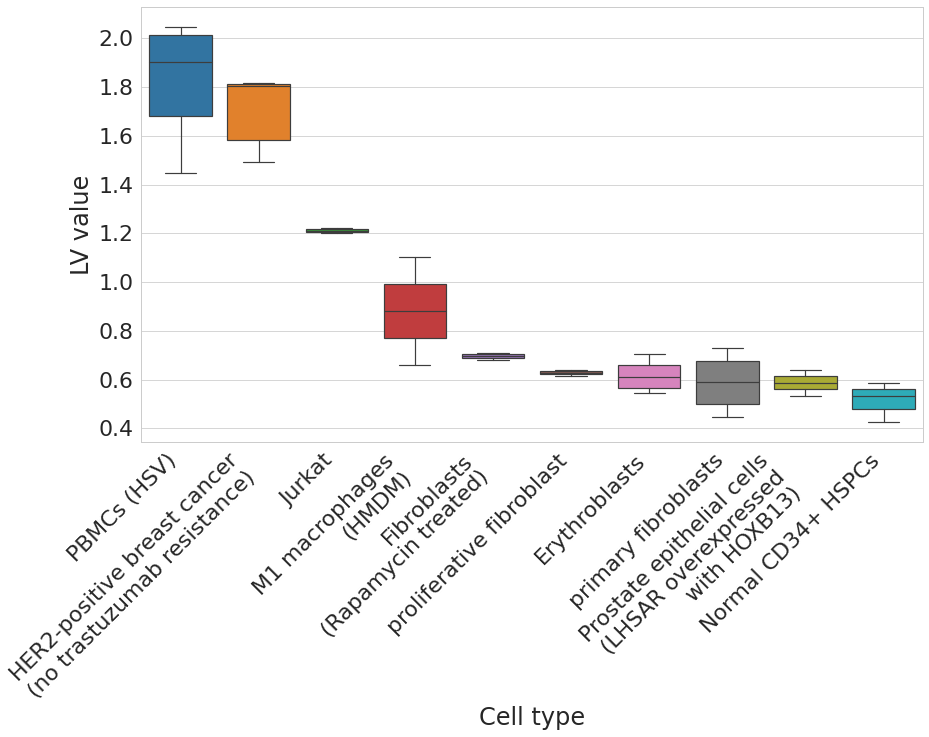

In [165]:
with sns.plotting_context("paper", font_scale=2.5), sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(14, 8))
    ax = sns.boxplot(
        data=df,
        x="attr",
        y="lv",
        order=cat_order,
        linewidth=None,
        ax=ax,
    )
    ax.set_xlabel("Cell type")
    ax.set_ylabel("LV value")
    plt.xticks(rotation=45, horizontalalignment="right")

    output_filepath = OUTPUT_FIGURES_DIR / "niacin-cad-modules_cell_types.svg"
    display(output_filepath)
    plt.savefig(
        output_filepath,
        bbox_inches="tight",
    )

In [129]:
df_tmp = pd.concat(cell_type_dfs[:N_TOP_LVS], ignore_index=False).reset_index()

In [157]:
df_tmp[df_tmp["attr"].str.contains("Neutrophils")]

,project,run,lv,attr,lv_name
6849,SRP045500,SRR1551040,2.307126,Neutrophils,LV116
6859,SRP045500,SRR1550997,1.730614,Neutrophils,LV116
6862,SRP045500,SRR1551101,1.651573,Neutrophils,LV116
6933,SRP045500,SRR1551047,0.493593,Neutrophils,LV116
6992,SRP045500,SRR1551054,0.393106,Neutrophils,LV116
7114,SRP045500,SRR1550986,0.130220,Neutrophils,LV116
7128,SRP045500,SRR1551082,0.118749,Neutrophils,LV116
7538,SRP045500,SRR1551088,0.016866,Neutrophils,LV116
7606,SRP045500,SRR1551068,0.012291,Neutrophils,LV116
7607,SRP045500,SRR1551075,0.012157,Neutrophils,LV116


In [158]:
lv_name = "LV116"
lv_obj = LVAnalysis(lv_name, data)

In [159]:
lv_obj.lv_genes.head(10)

,gene_name,LV116,gene_band
0,IFIT1,6.937650,10q23.31
1,MX1,6.650584,21q22.3
2,IFIT2,6.479595,10q23.31
3,OAS3,6.311481,12q24.13
4,OASL,6.212510,12q24.31
5,IFIT3,5.990415,10q23.31
6,OAS2,5.873026,12q24.13
7,OAS1,5.701188,12q24.13
8,MX2,5.549364,21q22.3
9,RSAD2,5.244291,2p25.2


In [160]:
lv_data = lv_obj.get_experiments_data()

SRP059039, SRP045500, SRP063059, SRP045569, SRP015670, SRP059531, SRP062958, SRP039361, SRP056733, SRP060370, SRP062966, SRP045352, SRP048804, SRP032775, SRP059172, SRP050246, SRP064458, SRP033711, SRP049820, SRP023199, SRP060416, SRP005279, SRP042161, SRP059701, SRP068139, SRP051848, SRP014428, SRP063661, SRP057205, SRP041826, SRP059057, SRP064259, SRP046226, SRP044956, SRP066356, SRP048640, SRP041885, SRP045659, SRP041647, SRP045565, SRP041620, SRP053186, SRP045441, SRP022133, SRP055874, SRP029990, SRP044206, SRP065763, SRP056443, SRP041538, SRP044593, SRP019270, SRP067934, SRP059035, SRP019936, SRP054971, SRP058237, SRP051368, SRP019758, 

In [161]:
lv_data.shape

(4274, 105)

In [163]:
lv_data.loc[["SRP045500"]].dropna(how="all", axis=1).sort_values(
    lv_name, ascending=False
).head(60)

age  cellcount     celltype   collectiondate  \
project   run                                                       
SRP045500 SRR1551040  36   34537500  Neutrophils     June 29 2012   
          SRR1550997  52  190000000  Neutrophils      May 22 2012   
          SRR1551101  35   10237500  Neutrophils   August 24 2012   
          SRR1551046  36         --  Whole Blood     June 29 2012   
          SRR1550983  52         --  Whole Blood      May 22 2012   
          SRR1551107  35         --  Whole Blood   August 24 2012   
          SRR1551047  29   42250000  Neutrophils  January 25 2012   
          SRR1551054  22    3700000  Neutrophils  February 2 2012   
          SRR1551041  36    2000000    Monocytes     June 29 2012   
          SRR1550998  52    2000000    Monocytes      May 22 2012   
          SRR1551102  35    2000000    Monocytes   August 24 2012   
          SRR1551042  36     487967      B-cells     June 29 2012   
          SRR1550999  52     273769      B-cells      May 22 2012   
          SRR1551045  36     301460           NK     June 29 2012   
          SRR1551043  36    2000000          CD4     June 29 2012   
          SRR1551000  52    2000000          CD4      May 22 2012   
          SRR1551060  22         --  Whole Blood  February 2 2012   
          SRR1550986  32   14737500  Neutrophils     June 26 2012   
          SRR1551103  35     640619      B-cells   August 24 2012   
          SRR1551082  42   17550000  Neutrophils     June 19 2012   
          SRR1551001  52    2000000          CD8      May 22 2012   
          SRR1551053  29         --  Whole Blood  January 25 2012   
          SRR1551104  35    2000000          CD4   August 24 2012   
          SRR1551044  36    2000000          CD8     June 29 2012   
          SRR1551106  35     310438           NK   August 24 2012   
          SRR1551105  35    1352936          CD8   August 24 2012   
          SRR1551055  22    2000000    Monocytes  February 2 2012   
          SRR1550981  32         --  Whole Blood     June 26 2012   
          SRR1551048  29    2000000    Monocytes  January 25 2012   
          SRR1551087  42         --  Whole Blood     June 19 2012   
          SRR1551050  29    2000000          CD4  January 25 2012   
          SRR1551088  21   12825000  Neutrophils     June 20 2012   
          SRR1551056  22     363469      B-cells  February 2 2012   
          SRR1551068  30   17887500  Neutrophils   August 21 2012   
          SRR1551075  --   15862500  Neutrophils   August 22 2012   
          SRR1550987  32    2000000    Monocytes     June 26 2012   
          SRR1551049  29    2000000      B-cells  January 25 2012   
          SRR1551057  22    2000000          CD4  February 2 2012   
          SRR1551005  24    2000000          CD4      May 23 2012   
          SRR1551074  30         --  Whole Blood   August 21 2012   
          SRR1550989  32    1071990          CD4     June 26 2012   
          SRR1551002  24   19800000  Neutrophils      May 23 2012   
          SRR1551011  27    2000000          CD4      June 6 2012   
          SRR1551051  29    1500000          CD8  January 25 2012   
          SRR1550995  52    2000000          CD4      May 21 2012   
          SRR1550984  24         --  Whole Blood      May 23 2012   
          SRR1550988  32    1012333      B-cells     June 26 2012   
          SRR1551091  21    2000000          CD4     June 20 2012   
          SRR1551090  21     484043      B-cells     June 20 2012   
          SRR1551033  36   41000000  Neutrophils     June 28 2012   
          SRR1551084  42    1275892      B-cells     June 19 2012   
          SRR1551029  59    2000000          CD4      July 6 2012   
          SRR1551094  21         --  Whole Blood     June 20 2012   
          SRR1551023  39    2000000          CD4      July 5 2012   
          SRR1551085  42    2000000          CD4     June 19 2012   
          SRR1551064  --    2000000          CD4   August 16 2012   
          SRR155107

# Tissues

In [ ]:
df = pd.concat(tissue_dfs[:N_TOP_LVS], ignore_index=True)
# df = pd.concat([_get_lv_rank(x) for x in tissue_dfs[:N_TOP_LVS]], ignore_index=True)

In [ ]:
df.groupby("attr").mean().squeeze().sort_values(ascending=False).head(50)

# LV analysis

In [ ]:
lv_obj = LVAnalysis("LV116", data)

In [ ]:
lv_obj.lv_genes.head(20)

In [ ]:
lv_data = lv_obj.get_experiments_data()

In [ ]:
lv_data.shape

In [ ]:
_tmp = lv_data[["cell type", "LV116"]].dropna()

In [ ]:
_tmp[_tmp["cell type"].str.contains("M1")]

In [ ]:
_tmp[_tmp["cell type"].str.contains("CD14")]

In [ ]:
lv_obj2 = LVAnalysis("LV881", data)

In [ ]:
lv_obj2.lv_genes.head(20)

In [ ]:
lv_attrs = lv_obj.get_attributes_variation_score()
_tmp = pd.Series(lv_attrs.index)
lv_attrs = lv_attrs[
    _tmp.str.match(
        "(?:cell.+type$)|(?:tissue$)|(?:tissue.+type$)",
        case=False,
        flags=re.IGNORECASE,
    ).values
].sort_values(ascending=False)
display(lv_attrs)

In [ ]:
with sns.plotting_context("paper", font_scale=1.0), sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(14, 8))
    ax = lv_obj2.plot_attribute("tissue", top_x_values=20)

In [ ]:
with sns.plotting_context("paper", font_scale=1.0), sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(14, 8))
    ax = lv_obj2.plot_attribute("cell type", top_x_values=20)